
# Предсказание стоимости жилья

<div class="pull-right">

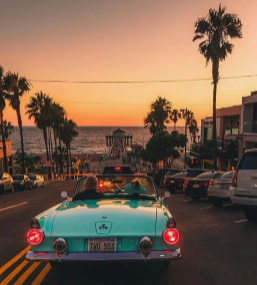

</div>

Необходимо обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году и предсказать медианную стоимость дома в жилом массиве.\
Для оценки качества модели требуется использовать метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:\
`longitude` — широта;\
`latitude` — долгота;\
`housing_median_age` — медианный возраст жителей жилого массива;\
`total_rooms` — общее количество комнат в домах жилого массива;\
`total_bedrooms` — общее количество спален в домах жилого массива;\
`population` — количество человек, которые проживают в жилом массиве;\
`households` — количество домовладений в жилом массиве;\
`median_income` — медианный доход жителей жилого массива;\
`median_house_value` — медианная стоимость дома в жилом массиве;\
`ocean_proximity` — близость к океану.




## Загрузка и изучение данных

In [1]:
import pandas as pd 
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

In [2]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("California - Linear regression") \
                    .getOrCreate()

In [3]:
df = spark.read.option('header', 'true').csv('../../13 системы обработки больших данных/project/housing.csv', 
                                             inferSchema = True)

In [4]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [5]:
df.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



In [6]:
df.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [7]:
# количество пропусков в каждом признаке
columns = df.columns
for column in columns:
    print(column, df.filter(F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


## Предобработка данных

In [8]:
# медиана 'total_bedrooms'
total_bedrooms_median = df.approxQuantile('total_bedrooms', [0.5], 0)[0]
total_bedrooms_median

435.0

In [9]:
# заполняем пропуски медианой всего признака
df = df.na.fill({'total_bedrooms': total_bedrooms_median})

In [10]:
# создаём новые признаки
df = df.withColumn('rooms_per_household', F.col('total_rooms')/F.col('households')) # среднее число комнат в доме в ж.массиве
df = df.withColumn('population_in_household', F.col('population')/F.col('households')) # среднее число жильцов в доме в ж.м.

## Machine learning

In [11]:
# разбиваем датасет на обучающую, валидационную и тестовую выборки (0.6/0.2/0.2)
train_data, valid_test_data =              df.randomSplit([.6,.4], seed=2022)
valid_data,       test_data = valid_test_data.randomSplit([.5,.5], seed=2022)

In [12]:
# число объектов в выборках
print(f'train = {train_data.count()}, valid = {valid_data.count()}, test = {test_data.count()}')

train = 12336, valid = 4179, test = 4125


In [13]:
def ml(train, test, categorical_cols, numerical_cols):
    '''расчитывает метрики качества (RMSE,MAE,R2) модели линеной регрессии в зависимости от набора признаков;
       в процессе производится кодирование, масштабирование, обучение, предсказание, оценка'''
    
    # кодируем категориальные признаки
    indexer = StringIndexer(inputCols=categorical_cols, outputCols=[c+'_idx' for c in categorical_cols], handleInvalid = 'keep')
    indexer = indexer.fit(train)
    train_cod = indexer.transform(train)
    test_cod  = indexer.transform(test)
    
    # кодируем категориальные признаки (OHE)
    encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols], outputCols=[c+'_ohe' for c in categorical_cols])
    encoder = encoder.fit(train_cod)
    train_cod = encoder.transform(train_cod)
    test_cod  = encoder.transform(test_cod)
    
    # объединение категориальных признаков в 1 вектор
    categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],outputCol='categorical_features')
    train_cod = categorical_assembler.transform(train_cod)
    test_cod  = categorical_assembler.transform(test_cod)
    
    # объединение количественных признаков в 1 вектор
    numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')
    train_cod = numerical_assembler.transform(train_cod)
    test_cod  = numerical_assembler.transform(test_cod)
    
    # скалирование количественных данных
    standardScaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')
    standardScaler = standardScaler.fit(train_cod)
    train_cod = standardScaler.transform(train_cod)
    test_cod  = standardScaler.transform(test_cod)
    
    # объединяем количественные и категориальные признаки
    all_features = ['categorical_features','numerical_features_scaled']
    final_assembler = VectorAssembler(inputCols=all_features, outputCol='features')
    train_cod = final_assembler.transform(train_cod)
    test_cod  = final_assembler.transform(test_cod)
    
    # обучение модели линейной регрессии
    lr = LinearRegression(labelCol='median_house_value', featuresCol='features')
    model = lr.fit(train_cod)
    
    # предсказание
    predictions = model.transform(test_cod)
    predictedLabes_rdd = predictions.select('prediction', 'median_house_value').rdd
    
    metrics = RegressionMetrics(predictedLabes_rdd)
    
    return print(f'RMSE = {metrics.rootMeanSquaredError:.0f}, MAE = {metrics.meanAbsoluteError:.0f}, R2 = {metrics.r2:.3f}')

### Подбор признаков

#### Все признаки

In [14]:
categorical_cols = ['ocean_proximity']
numerical_cols   = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [15]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 5141199, MAE = 187844, R2 = -2006.300


#### Без новых сгенерированных признаков

In [16]:
categorical_cols = ['ocean_proximity']
numerical_cols   = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households',
                    'median_income']

In [17]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 4895971, MAE = 181197, R2 = -1819.377


#### С новыми сгенерированными, но без мультиколлинеарных

In [18]:
categorical_cols = ['ocean_proximity']
numerical_cols   = ['longitude','latitude','housing_median_age','total_bedrooms','households',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [19]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 5066866, MAE = 188495, R2 = -1948.675


#### С новыми сгенерированными, но без мультиколлинеарных (вар.2)

In [20]:
categorical_cols = ['ocean_proximity']
numerical_cols   = ['longitude','latitude','housing_median_age','total_bedrooms',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [21]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 4908751, MAE = 184337, R2 = -1828.893


#### С новыми сгенерированными, но без мультиколлинеарных (вар.3)

In [22]:
categorical_cols = ['ocean_proximity']
numerical_cols   = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [23]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 5344839, MAE = 193599, R2 = -2168.466


#### Все признаки, но без 'longitude','latitude'

In [24]:
categorical_cols = ['ocean_proximity']
numerical_cols   = ['housing_median_age','total_rooms','total_bedrooms','population','households',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [25]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 87116, MAE = 51854, R2 = 0.424


#### Только количественные признаки

In [26]:
categorical_cols = []
numerical_cols   = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [27]:
ml(train_data, valid_data, categorical_cols, numerical_cols)

RMSE = 68615, MAE = 51299, R2 = 0.642


Лучший результат у набора признаков без категориального.

### Проверка выбранной модели на тестовой выборке

In [28]:
categorical_cols = []
numerical_cols   = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households',
                    'median_income', 'rooms_per_household', 'population_in_household']

In [29]:
ml(train_data, test_data, categorical_cols, numerical_cols)

RMSE = 69261, MAE = 50681, R2 = 0.644


## Вывод

* в исходном датасете 10 признаков и 20640 объектов;
* в признаке 'total_bedrooms' 207 пропусков (1%); заполнил медианным значением;
* создал новые признаки - среднее число комнат в доме в жил.массиве и среднее число жильцов в доме в ж.м.;
* обучил модель линейной регрессии для предсказания медианной стоимости дома в ж.массиве.; перебрал 7 вариаций признаков подаваемых в модель для обучения;
* лучший результат у модели с максимальным числом признаков, но без категориального 'ocean_proximity';
* метрики качества лучшей модели на валидационной выборке: RMSE = 68615, MAE = 51299, R2 = 0.642;
* метрики качества лучшей модели на тестовой выборке: RMSE = 69261, MAE = 50681, R2 = 0.644.